In [1]:

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta
import os.path


def read_lcl():
    """
    Read LCL from RV Maria S Merian

    Returns
    -------
    ds: lifting condensation level dataset
    """

    ds = xr.open_dataset(
        os.path.join(
            "/data/obs/campaigns/eurec4a/msm/LCL_dataset.nc",
        )
    )

    return ds


def convert_local_time_and_reorder_for_time_hh_mm(data):
    """
    function to convert time array of diurnal cycle data from UTC to local time and reorder 
    data with respect to hh:mm, displaying diurnal cycle correctly.
    

    Args:
        data (xarray dataset): data to reorder
    Returns:
        data_sorted
    """
    data['Time'] = pd.to_datetime(data.Time.values) - timedelta(hours=4)
    times = pd.to_datetime(data.Time.values)
    times_hh = times.hour
    times_mm = times.minute
    num_times= np.arange(0,len(times_mm))
    times_new = ([datetime(2000,1,1,times_hh[i], times_mm[i]) for i in num_times])
    data['Time'] = times_new
    data_sorted = data.sortby('Time')
    
    return(data_sorted)


def read_all_lidar_diurnal_cycle_files(path_to_file):
    """function to read all lidar diurnal cycle files and 
    convert them to local time 
    
    arguments:
    path_to_file: string, path to the file directory
    dependencies:
    
    convert_local_time_and_reorder_for_time_hh_mm
    
    returns (list of xarray dataset)
    """
    T_data = xr.open_dataset(path_to_file+'T_diurnal_cycle.nc')
    MR_data = xr.open_dataset(path_to_file+'MR_diurnal_cycle.nc')
    VW_data = xr.open_dataset(path_to_file+'VW_diurnal_cycle.nc')

    data_array = [T_data, MR_data, VW_data]
    var_list = ['T','MR','VW']
    # convert time to local time (UTC - 4)
    data_lt = []
    
    for i, data in enumerate(data_array):
        var_name = var_list[i]
        data_new = convert_local_time_and_reorder_for_time_hh_mm(data)
        data_new = data_new.rename({'diurnal_cycle':var_name})
        data_lt.append(data_new)
        
    data_out = xr.merge(data_lt)
    return(data_out)

def read_h_wind(path_to_file):
    """function to read all lidar diurnal cycle files and 
    convert them to local time 
    
    arguments:
    path_to_file: string, path to the file directory
    dependencies:
    
    convert_local_time_and_reorder_for_time_hh_mm
    
    returns (list of xarray dataset)
    """
    H_wind_data = xr.open_dataset(path_to_file+'H_wind_speed_diurnal_cycle.nc')


    data_array = [ H_wind_data]
    var_list = [ 'HW']
    # convert time to local time (UTC - 4)
    data_lt = []
    
    for i, data in enumerate(data_array):
        var_name = var_list[i]
        data_new = convert_local_time_and_reorder_for_time_hh_mm(data)
        data_new = data_new.rename({'diurnal_cycle':var_name, 'Time':'time_h', 'Height':'height_h'})
        
        data_lt.append(data_new)

    data_out = xr.merge(data_lt, join='inner' )
    return(data_out)


def read_fluxes(path_to_file):
    """function to read all lidar diurnal cycle files and 
    convert them to local time 
    
    arguments:
    path_to_file: string, path to the file directory
    dependencies:
    
    convert_local_time_and_reorder_for_time_hh_mm
    
    returns (list of xarray dataset)
    """
    LHF_data = xr.open_dataset(path_to_file+'LHF_diurnal_cycle.nc')
    SHF_data = xr.open_dataset(path_to_file+'SHF_diurnal_cycle.nc')

    data_array = [ LHF_data, SHF_data]
    var_list = [ 'LHF', 'SHF']
    # convert time to local time (UTC - 4)
    data_lt = []
    
    for i, data in enumerate(data_array):
        var_name = var_list[i]
        data_new = convert_local_time_and_reorder_for_time_hh_mm(data)
        data_new = data_new.rename({'diurnal_cycle':var_name, 'Time':'time_coarse', 'Height':'height_coarse'})
        
        data_lt.append(data_new)

    data_out = xr.merge(data_lt, join='inner', )
    return(data_out)
path_diurnal_cycle_arthus = '/net/ostro/4sibylle/diurnal_cycle_arthus/5_mins/diurnal_cycle/'


In [2]:

# add lidar data diurnal cycle
lidar_ds = read_all_lidar_diurnal_cycle_files(path_diurnal_cycle_arthus)
fluxes_ds = read_fluxes(path_diurnal_cycle_arthus)
hw_ds = read_h_wind(path_diurnal_cycle_arthus)


def calc_diurnal_lcl(ds, path_out, avg_time='15'):
    '''
    function to calculate diurnal cycle for lcl data

    '''
    # calculating the mean of the variable over the time interval requested
    ds = ds.resample(time=avg_time+'T').mean()
    # re-writing time array as hh:mm for then being able to group
    ds['time'] = pd.to_datetime(ds.time.values).strftime("%H:%M")
    # grouping and calculating mean of the profiles
    grouped_mean = ds.groupby('time').mean()
    
    
    # storing diurnal cycle in ncdf file
    dims             = ['time']
    coords           = {"time":pd.to_datetime(grouped_mean['time'].values)}
    lcl_diurnal  = xr.DataArray(dims=dims, coords=coords, data=grouped_mean['lcl'].values,\
                         attrs={'long_name':'diurnal cycle over '+avg_time+'min for '+'lcl',\
                                'units':'m'})
    
    global_attributes = {'CREATED_BY'       : 'Claudia Acquistapace',
                        'CREATED_ON'       :  str(datetime.now()),
                        'FILL_VALUE'       :  'NaN',
                        'AUTHOR_NAME'          : 'Claudia Acquistapace',
                        'AUTHOR_AFFILIATION'   : 'University of Cologne (UNI), Germany',
                        'AUTHOR_ADDRESS'       : 'Institute for geophysics and meteorology, Pohligstrasse 3, 50969 Koeln',
                        'AUTHOR_MAIL'          : 'cacquist@meteo.uni-koeln.de',
                        'DATA_DESCRIPTION' : 'diurnal cycle of the surface weather station variables calculated on '+avg_time+'minutes',
                        'DATA_DISCIPLINE'  : 'Atmospheric Physics - weather station on wband radar',
                        'DATA_GROUP'       : 'Experimental;Moving',
                        'DATA_SOURCE'      : 'wband radar data',
                        'DATA_PROCESSING'  : 'https://github.com/ClauClouds/rain_paper_QJRSM/',
                        'INSTRUMENT_MODEL' : '',
                         'COMMENT'         : 'original data postprocessed by Claudia Acquistapace' }
    ds_lcl_dc    = xr.Dataset(data_vars = {'lcl_dc':lcl_diurnal},
                                       coords = coords,
                                       attrs = global_attributes)
    # storing data to ncdf
    ds_lcl_dc.to_netcdf(path_out+'_lcl_diurnal_cycle.nc',
                   encoding={'lcl_dc':{"zlib":True, "complevel":9},\
                    "time": {"units": "seconds since 2020-01-01", "dtype": "i4"}})
    
    return ds_lcl_dc
    
    
# read lcl and calculate its diurnal cycle
ds_lcl = read_lcl()
ds_lcl_diurnal = calc_diurnal_lcl(ds_lcl, path_diurnal_cycle_arthus, '30')
        

In [3]:
print(fluxes_ds)

<xarray.Dataset>
Dimensions:        (time_coarse: 48, height_coarse: 57)
Coordinates:
  * time_coarse    (time_coarse) datetime64[ns] 2000-01-01 ... 2000-01-01T23:...
  * height_coarse  (height_coarse) float32 225.0 275.0 ... 2.975e+03 3.025e+03
Data variables:
    LHF            (time_coarse, height_coarse) float32 ...
    SHF            (time_coarse, height_coarse) float32 ...
Attributes: (12/14)
    CREATED_BY:          Claudia Acquistapace
    CREATED_ON:          2024-08-20 11:14:53.663497
    FILL_VALUE:          NaN
    AUTHOR_NAME:         Claudia Acquistapace
    AUTHOR_AFFILIATION:  University of Cologne (UNI), Germany
    AUTHOR_ADDRESS:      Institute for geophysics and meteorology, Pohligstra...
    ...                  ...
    DATA_DISCIPLINE:     Atmospheric Physics - Remote Sensing Lidar Profiler
    DATA_GROUP:          Experimental;Profile;Moving
    DATA_SOURCE:         arthus data
    DATA_PROCESSING:     https://github.com/ClauClouds/SST-impact/
    INSTRUMENT_MODE

In [4]:
print(ds_lcl_diurnal)

<xarray.Dataset>
Dimensions:  (time: 48)
Coordinates:
  * time     (time) datetime64[ns] 2024-08-23 ... 2024-08-23T23:30:00
Data variables:
    lcl_dc   (time) float64 634.1 621.4 641.3 630.9 ... 647.2 633.0 627.1 629.4
Attributes: (12/14)
    CREATED_BY:          Claudia Acquistapace
    CREATED_ON:          2024-08-23 18:47:42.918024
    FILL_VALUE:          NaN
    AUTHOR_NAME:         Claudia Acquistapace
    AUTHOR_AFFILIATION:  University of Cologne (UNI), Germany
    AUTHOR_ADDRESS:      Institute for geophysics and meteorology, Pohligstra...
    ...                  ...
    DATA_DISCIPLINE:     Atmospheric Physics - weather station on wband radar
    DATA_GROUP:          Experimental;Moving
    DATA_SOURCE:         wband radar data
    DATA_PROCESSING:     https://github.com/ClauClouds/rain_paper_QJRSM/
    INSTRUMENT_MODEL:    
    COMMENT:             original data postprocessed by Claudia Acquistapace


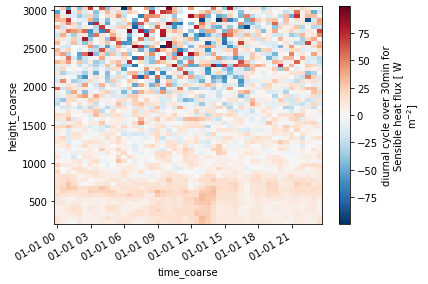

In [5]:
fluxes_ds.SHF.plot(x='time_coarse', y='height_coarse')

In [6]:

def calc_lcl_grid(ds, lcl_ds, height_var, time_var, var_name):
    
    dz = 7.45

    # rename time and height in standard way for processing
    ds = ds.rename({height_var:'height', time_var:'time'})

    # adding lcl to the dataset variables (also diurnal cycle)
    ds['lcl_dc'] = lcl_ds.lcl_dc.values
    
    # reading dataarray of the input variable and of lcl
    da_var = ds[var_name]
    da_lcl = ds.lcl_dc

    # interpolate data on regular height grid of 7.45 m that covers the
    # height difference to the lcl
    z_rel = np.arange(
        da_var.height.min() - da_lcl.max(),
        da_var.height.max() - da_lcl.min() + dz,
        dz,
    )
    z_rel = z_rel - z_rel[z_rel > 0].min()  # center around zero

    da_var = da_var.interp(
        height=z_rel, method="nearest", kwargs={"fill_value": 0}
    )

    
    # calculate shift of all height values at each time step
    # positive shift means each height bin is shifted downward
    rows, columns = np.ogrid[: da_var.shape[0], : da_var.shape[1]]  # 2d indices
    shift = ((da_lcl + dz / 2) // dz).values.astype("int16")
    columns = columns + shift[:, np.newaxis]
    columns[columns >= columns.shape[1]] = columns.shape[1] - 1  # upper bound
    da_var[:] = da_var.values[rows, columns]
    
    return(da_var)
    
#hw_lcl = calc_lcl_grid(hw_ds, ds_lcl_diurnal, 'height_h', 'time_h', 'HW')
#T_lcl = calc_lcl_grid(lidar_ds, ds_lcl_diurnal, 'Height', 'Time', 'MR')
#T_lcl.plot(x='time', y='height')
SF_lcl = calc_lcl_grid(fluxes_ds, ds_lcl_diurnal, 'height_coarse', 'time_coarse', 'SHF')
#hw_lcl = calc_lcl_grid(fluxes_ds, ds_lcl_diurnal, 'height_coarse', 'time_coarse', 'SHF')


[Text(0, -1.0, '-1.0'),
 Text(0, -0.5, '-0.5'),
 Text(0, 0.0, 'LCL'),
 Text(0, 0.5, '0.5')]

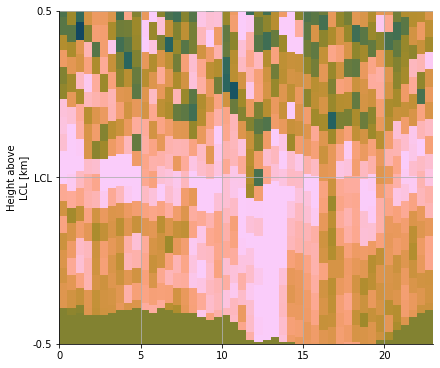

In [18]:
import matplotlib.colors as mcolors
from mpl_style import CMAP, COLOR_CONGESTUS, COLOR_SHALLOW
from matplotlib.colors import ListedColormap
none_map = ListedColormap(['none'])
fig, axes = plt.subplots(figsize=(6, 5), constrained_layout=True)

mask_T = np.ma.masked_where(SF_lcl.values > 0, SF_lcl.values)

kwargs = dict(shading="nearest", cmap=CMAP)
im = axes.pcolormesh(
    pd.to_datetime(SF_lcl.time.values).hour,
    SF_lcl.height * 1e-3,
    SF_lcl.T,
    vmin=-20,
    vmax=20,
    **kwargs
)    
axes.set_ylabel("Height above\nLCL [km]")

cs = axes.contourf(pd.to_datetime(SF_lcl.time.values).hour,
    SF_lcl.height.values* 1e-3,
    mask_T.T, 
    hatches='//',
    cmap='Greys', extend='both', alpha=0.5)

axes.set_yticks(np.arange(-1, 1, 0.5))
axes.set_ylim(-0.5, 0.5)

# shallow axis
axes.set_yticklabels([-1., -0.5, "LCL", 0.5])
#axes.set_ylim(
#    [
#        SF_lcl.height.isel(
#            height=SF_lcl.any("time").values.argmax()
#        )
#        * 1e-3,
#        0.3,
#    ]
#)



In [141]:
print(SF_lcl.height.isel(height=SF_lcl.any("time").values.argmax())* 1e-3)

<xarray.DataArray 'height' ()>
array(-0.52895)
Coordinates:
    height   float64 -529.0


In [12]:
path_to_file = '/work/4sibylle/diurnal_cycle_arthus/5_mins/diurnal_cycle/'

def convert_local_time_and_reorder_for_time_hh_mm(data):
    """
    function to convert time array of diurnal cycle data from UTC to local time and reorder 
    data with respect to hh:mm, displaying diurnal cycle correctly.
    

    Args:
        data (xarray dataset): data to reorder
    Returns:
        data_sorted
    """
    data['Time'] = pd.to_datetime(data.Time.values) - timedelta(hours=4)
    times = pd.to_datetime(data.Time.values)
    times_hh = times.hour
    times_mm = times.minute
    num_times= np.arange(0,len(times_mm))
    times_new = ([datetime(2000,1,1,times_hh[i], times_mm[i]) for i in num_times])
    data['Time'] = times_new
    data_sorted = data.sortby('Time')
    
    return(data_sorted)


def read_all_lidar_diurnal_cycle_files(path_to_file):
    """function to read all lidar diurnal cycle files and 
    convert them to local time 
    
    arguments:
    path_to_file: string, path to the file directory
    dependencies:
    
    convert_local_time_and_reorder_for_time_hh_mm
    
    returns (list of xarray dataset)
    """
    T_data = xr.open_dataset(path_to_file+'T_diurnal_cycle.nc')
    MR_data = xr.open_dataset(path_to_file+'MR_diurnal_cycle.nc')
    LHF_data = xr.open_dataset(path_to_file+'LHF_diurnal_cycle.nc')
    SHF_data = xr.open_dataset(path_to_file+'SHF_diurnal_cycle.nc')
    VW_data = xr.open_dataset(path_to_file+'VW_diurnal_cycle.nc')
    H_wind_data = xr.open_dataset(path_to_file+'H_wind_speed_diurnal_cycle.nc')

    data_array = [T_data, MR_data, VW_data, H_wind_data, LHF_data, SHF_data, ]

    # convert time to local time (UTC - 4)
    data_lt = []
    for i, data in enumerate(data_array):
        data_lt.append(convert_local_time_and_reorder_for_time_hh_mm(data))
        
    return(data_lt)



def read_all_lidar_diurnal_cycle_files_2(path_to_file):
    """function to read all lidar diurnal cycle files and 
    convert them to local time 
    
    arguments:
    path_to_file: string, path to the file directory
    dependencies:
    
    convert_local_time_and_reorder_for_time_hh_mm
    
    returns (list of xarray dataset)
    """
    T_data = xr.open_dataset(path_to_file+'T_diurnal_cycle.nc')
    MR_data = xr.open_dataset(path_to_file+'MR_diurnal_cycle.nc')
    LHF_data = xr.open_dataset(path_to_file+'LHF_diurnal_cycle.nc')
    SHF_data = xr.open_dataset(path_to_file+'SHF_diurnal_cycle.nc')
    VW_data = xr.open_dataset(path_to_file+'VW_diurnal_cycle.nc')
    H_wind_data = xr.open_dataset(path_to_file+'H_wind_speed_diurnal_cycle.nc')

    data_array = [T_data, MR_data, VW_data, H_wind_data]
    var_list = ['T','MR','VW', 'HW']
    # convert time to local time (UTC - 4)
    data_lt = []
    
    for i, data in enumerate(data_array):
        var_name = var_list[i]
        data_new = convert_local_time_and_reorder_for_time_hh_mm(data)
        data_new = data_new.rename({'diurnal_cycle':var_name})
        data_lt.append(data_new)
        
    data_out = xr.merge(data_lt)
    return(data_out)

#data = read_all_lidar_diurnal_cycle_files_2(path_to_file)


def read_fluxes(path_to_file):
    """function to read all lidar diurnal cycle files and 
    convert them to local time 
    
    arguments:
    path_to_file: string, path to the file directory
    dependencies:
    
    convert_local_time_and_reorder_for_time_hh_mm
    
    returns (list of xarray dataset)
    """
    LHF_data = xr.open_dataset(path_to_file+'LHF_diurnal_cycle.nc')
    SHF_data = xr.open_dataset(path_to_file+'SHF_diurnal_cycle.nc')

    data_array = [ LHF_data, SHF_data]
    var_list = [ 'LHF', 'SHF']
    # convert time to local time (UTC - 4)
    data_lt = []
    
    for i, data in enumerate(data_array):
        var_name = var_list[i]
        data_new = convert_local_time_and_reorder_for_time_hh_mm(data)
        data_new = data_new.rename({'diurnal_cycle':var_name})
        data_lt.append(data_new)

    data_out = xr.merge(data_lt, join='inner', )
    return()

data = read_all_lidar_diurnal_cycle_files_2(path_to_file)
fluxes = read_fluxes(path_to_file)
print(data)

<xarray.Dataset>
Dimensions:  (Time: 96, Height: 457)
Coordinates:
  * Time     (Time) datetime64[ns] 2000-01-01 ... 2000-01-01T23:45:00
  * Height   (Height) float64 0.0 21.21 42.42 ... 8.42e+03 8.442e+03 8.463e+03
Data variables:
    T        (Time, Height) float32 nan nan nan nan nan ... nan nan nan nan nan
    MR       (Time, Height) float32 nan nan nan nan nan ... nan nan nan nan nan
    VW       (Time, Height) float32 nan nan nan nan nan ... nan nan nan nan nan
    HW       (Time, Height) float64 4.052 5.825 8.976 9.169 ... nan nan nan nan
Attributes: (12/14)
    CREATED_BY:          Claudia Acquistapace
    CREATED_ON:          2024-08-19 13:16:05.541536
    FILL_VALUE:          NaN
    AUTHOR_NAME:         Claudia Acquistapace
    AUTHOR_AFFILIATION:  University of Cologne (UNI), Germany
    AUTHOR_ADDRESS:      Institute for geophysics and meteorology, Pohligstra...
    ...                  ...
    DATA_DISCIPLINE:     Atmospheric Physics - Remote Sensing Lidar Profiler
    DA

0
T [K]


NameError: name 'data_lt' is not defined

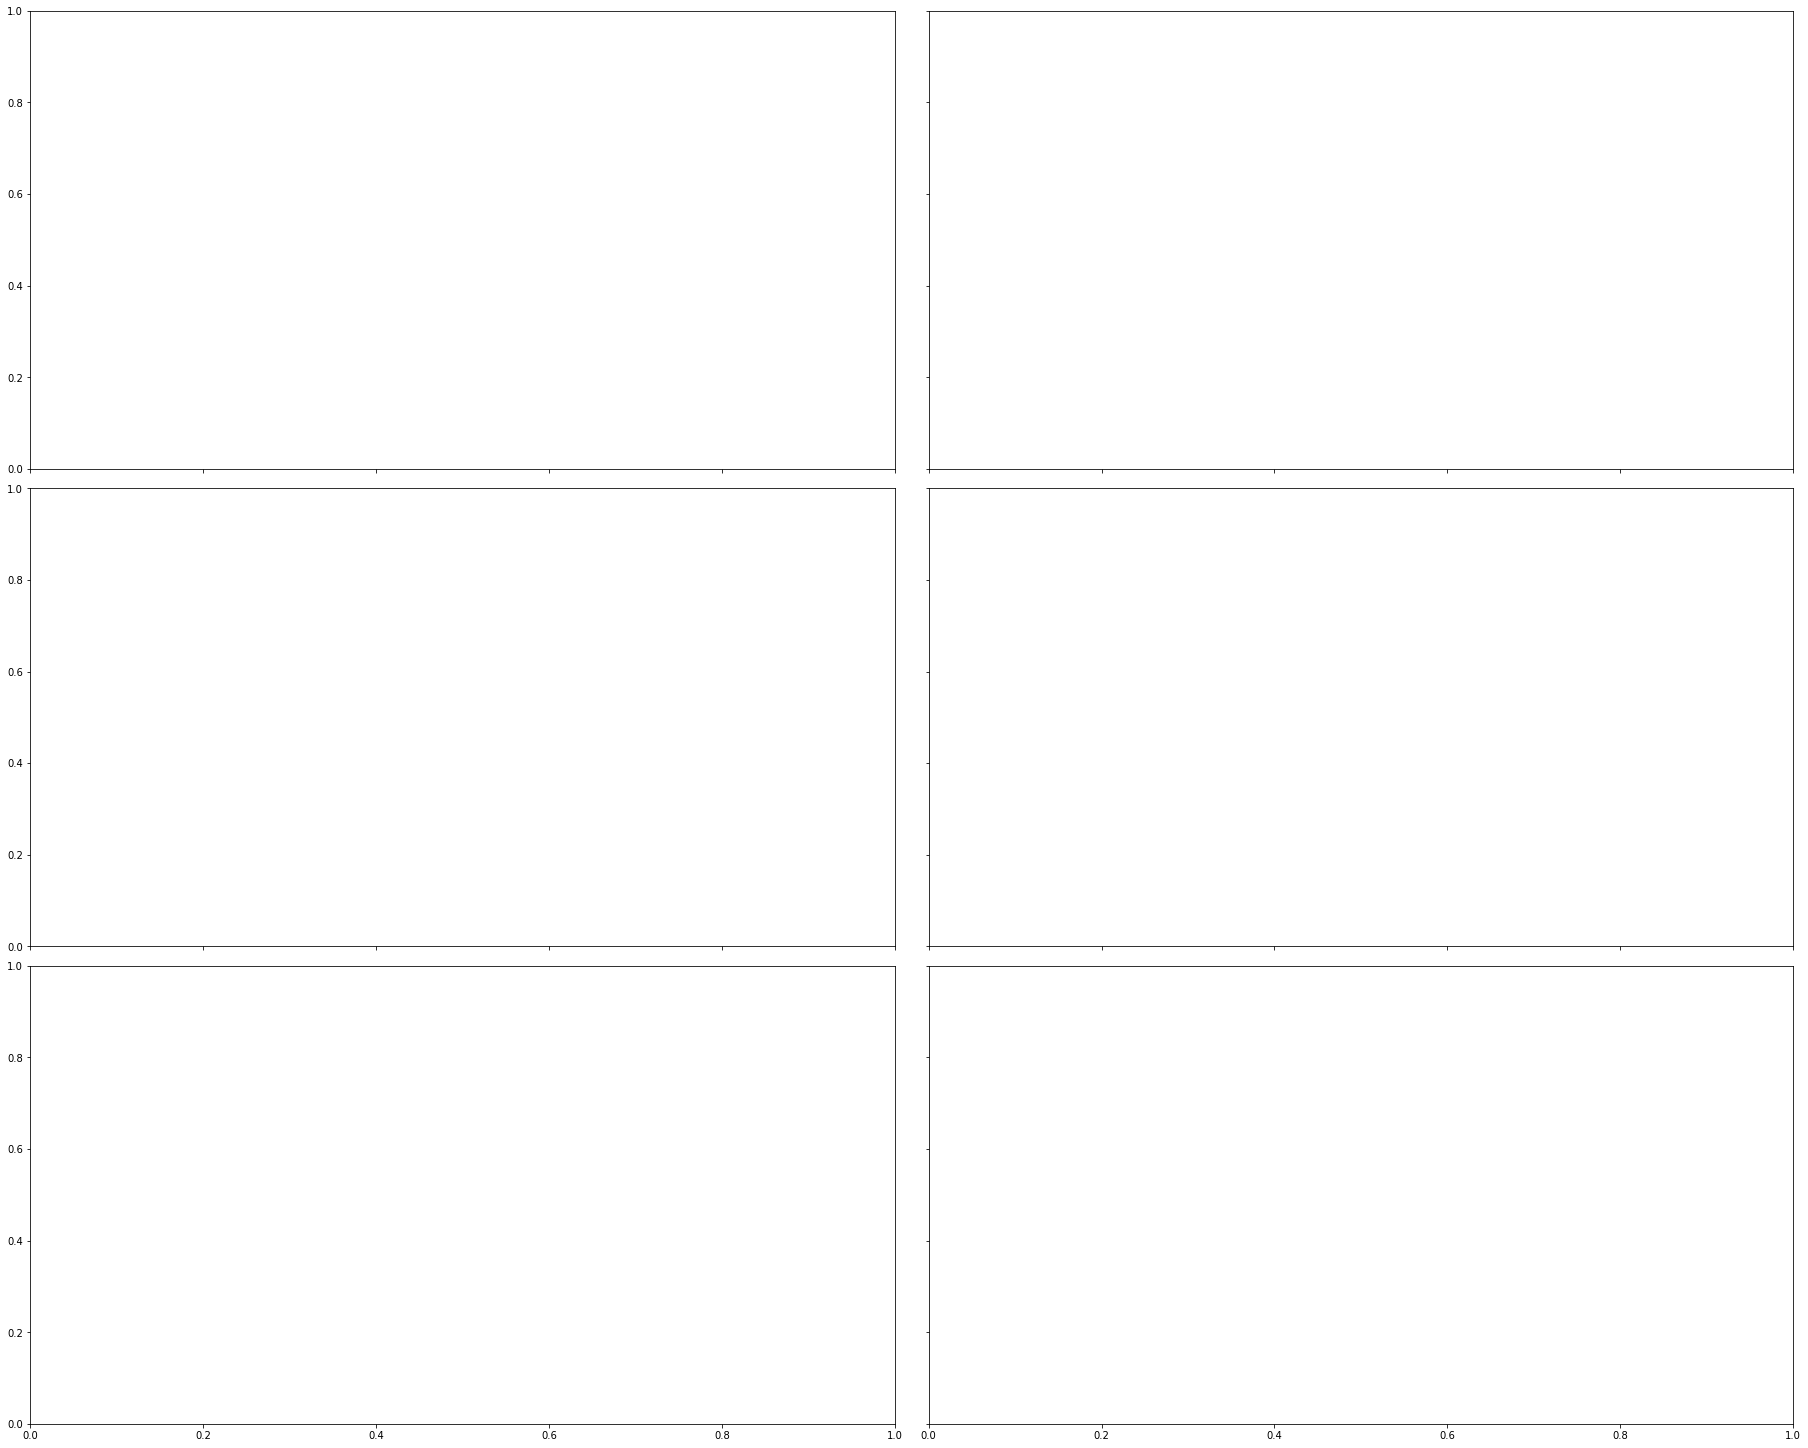

In [6]:
 # plot diurnal cycle 
 
 units_arr = ['T [K]', 
             'MR [gm$^{-2}$]', 
             'W [ms$^{-1}$]',
             'u$^2$+v$^2$ [ms$^{-1}$]',
             'LHF [Wm$^{-2}$]', 
             'SHF [Wm$^{-2}$]']
vmin_arr = [290,
            10,
            -1,
            6,
            -30,
            -20,]
vmax_arr = [300, 
            16, 
            1, 
            10,
            100,
            20,
            ]
 
fig2, axs = plt.subplots(3,2, figsize=(25,20), sharex=True, sharey=True, constrained_layout=True)

ind_dataset = 0
for i in range(0,3):
    for j in range(0,2):
        print(ind_dataset)
        print(units_arr[ind_dataset])
        # reading input data
        data = data_lt[ind_dataset]
                
        # plot map of the variable
        mesh = axs[i,j].pcolormesh(data['Time'].values, 
                            data['Height'].values,
                            data['diurnal_cycle'].values.T,
                            cmap='viridis',
                            vmin=vmin_arr[ind_dataset], 
                            vmax=vmax_arr[ind_dataset],
                            rasterized=True)
        cbar = fig2.colorbar(mesh, location='right', aspect=20)
        
        cbar.ax.tick_params(labelsize=20)
        cbar.ax.set_title(label=units_arr[ind_dataset],fontsize=20)
        axs[i,j].spines["top"].set_visible(False)
        axs[i,j].spines["right"].set_visible(False)
        axs[i,j].spines["bottom"].set_linewidth(3)
        axs[i,j].spines["left"].set_linewidth(3)
        #axs[i,j].xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
        #axs[i,j].tick_params(which='minor', length=5, width=2, labelsize = 5)
        #axs[i,j].xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
        axs[i,j].tick_params(axis='both', labelsize=20)
        axs[i,j].get_xaxis().tick_bottom()
        axs[i,j].get_yaxis().tick_left()
        axs[i,j].set_ylim(200.,1500.)
        axs[i,j].set_xlim(data.Time.values[0],data.Time.values[-1])

        axs[2,j].set_xlabel('Local time [UTC-4]', fontsize=20)
        axs[i,j].set_ylabel('Height [m]', fontsize=20)
        axs[i,j].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

        ind_dataset = ind_dataset+1



for ax, l in zip(axs[:,:].flatten(), ['a) Temperature', 
                                      'b) Mixing ratio',
                                      'c) Vertical velocity',
                                      'd) Horizontal wind speed', 
                                      'e) Latent heat flux', 
                                      'f) Sensible heat flux']):
    ax.text(-0.05, 1.07, l,  fontweight='black', fontsize=25, transform=ax.transAxes)
    
fig2.savefig(
os.path.join('/work/4sibylle/diurnal_cycle_arthus/5_mins/plots/', 'diurnal_cycle_overview.png'),
dpi=300,
bbox_inches="tight",
transparent=True,   
)
plt.close()